In [63]:
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from reportlab.pdfgen import canvas
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.svm import SVC 

In [2]:
class load_reshape(BaseEstimator,TransformerMixin):
    
    def __init__(self,Train="",Test=""):
        self.TrainFileName = Train
        self.TestFileName = Test
        self.X_train = []
        self.y_train = []
        self.X_test = []
        self.y_test = []
        
    def fit(self,*_):
        return self

    def transform(self,*_):
        T = h5py.File(self.TrainFileName)
        t = h5py.File(self.TestFileName)
        self.X_train = T['data'][:]
        self.y_train = T['label'][:]
        self.X_test= t['data'][:]
        self.y_test = t['label'][:]
        
        self.X_train = self.X_train.reshape(self.X_train.shape[0],255*255)
        self.X_test = self.X_test.reshape(self.X_test.shape[0], 255*255)
        return self.X_train, self.y_train, self.X_test, self.y_test

In [121]:
class Optimization(BaseEstimator,TransformerMixin):
     
    def __init__(self,estimator,parameters, RandSearchCV =True,
                 AdaBoostCLF = False, BaggCLF= False,GradBCLF =False ):
        self.estimator = estimator
        self.parameters = parameters
        self.RSCV = RandSearchCV
        self.ACLF = AdaBoostCLF
        self.BCLF = BaggCLF
        self.GBCLF = GradBCLF
    
        
    def fit(self,*_):
        return self
    
    def transform(self,X_train,y_train):
        if self.RSCV:
            RandS = RandomizedSearchCV(self.estimator, self.parameters, cv=10,
                                       n_jobs=4, verbose=10, random_state=42)
            return RandS.fit(X_train,y_train)
        if self.ACLF:
            AdaCL = AdaBoostClassifier(self.estimator,self.parameters)
            return AdaCL.fit(X_train,y_train)
        if self.BaggCLF:
            BagCL = BaggingClassifier(self.estimator,self.parameters)
            return BagCL.fit(X_train,y_train)
        if self.GBCLF:
            GradCL = GradientBoostingClassifier(self.estimator,self.parameters)
            return RandS.fit(X_train,y_train)
            


In [124]:
class TrainingModel(BaseEstimator,TransformerMixin):
    
    def __init__(self,Rfc = True, Knn = True, Svc = True):
        self.Rfc = Rfc
        self.Knn = Knn
        self.Svc = Svc
        
    def fit(self,*_):
        return self
    
    def transform(self,X_train,y_train):
        
        if self.Rfc:
            RandFC = RandomForestClassifier(bootstrap=False, criterion ='entropy',
             max_depth=6,random_state=42,verbose=30,n_estimators=100,n_jobs=4)
            return RandFC.fit(X_train,y_train)
        
        if self.Knn:
            KnnC = KNeighborsClassifier(n_neighbors=5,n_jobs=4)
            return KnnC.fit(X_train,y_train)
        
        if self.Svc:
            SupVeC = SVC(gamma="auto", verbose=30,random_state=42)
            return SupVeC.fit(X_train,y_train)
            

In [56]:
class Outcome(BaseEstimator,TransformerMixin):
    
    def __init__(self,attributes,Training_model,Optimus_model):
        self.Training_model = Training_model
        self.Optimus_model = Optimus_model
        self.attributes = attributes
        
    def fit(self,*_):
        return self
    
    def transform(self,X_train,X_test,y_test):
        y_pred = self.Training_model.predict(X_test)
        score = self.Training_model.score(X_test,y_pred)
        matriz_conf = confusion_matrix(y_test,y_pred,labels=[i for i in range(len(self.attributes))])
        accuracy = accuracy_score(y_pred,y_test)
        Best_Score = self.Optimus_model.best_score_
        Best_Params = self.Optimus_model.best_params_
        Classification_Report = classification_report(y_test, y_pred)
        
        return y_pred, score, matriz_conf, accuracy, Best_Score, Best_Params, Classification_Report
    

In [104]:
class Analyzation(BaseEstimator,TransformerMixin):
    def __init__(self,attributes,Prediction= True,Estimator_Score = True, MatrizConfusion = True,
                 accuracy = True, Best_Score= True,Best_Params=True,Class_Report = True):
        self.attributes = attributes    
        self.Pred = Prediction
        self.Sc = Estimator_Score 
        self.Ma = MatrizConfusion
        self.Ac = accuracy
        self.BS = Best_Score
        self.BP = Best_Params
        self.CP = Class_Report
        
    
    def fit(self,*_):
        return self
    
    def transform(self,task,Prediction,Estimator_Score,MatrizConfusion,accuracy,Best_Score,Best_Params,Class_Report):
        
        with open("%s1.txt"%task,"w") as stream:
            
            if(self.Pred):
                print('\033[1m Prediction: ' + '\033[1;34m {}\n'.format(Prediction) + '\033[0m')
                
                print('\033[1m Prediction: ' + '\033[1;34m {}\n'.format(Prediction) + '\033[0m', file=stream )


            if(self.Sc):
                print ('\033[1m Score: ' + '\033[1;34m {}\n'.format(Estimator_Score) + '\033[0m')
                
                print ('\033[1m Score: ' + '\033[1;34m {}\n'.format(Estimator_Score) + '\033[0m' , file = stream)

            if( self.Ac):
                print("\n Acuracy: %1.2f%%" % (accuracy.mean()*100))
                print("Margin of Error for More and Less: %1.2f%%" % (accuracy.std()*100))
                
                print("\n Acuracy: %1.2f%%" % (accuracy.mean()*100),file=stream)
                print("Margin of Error for More and Less: %1.2f%%" % (accuracy.std()*100),file=stream)

            if(self.BS):
                print('\033[1m Best Score: ' + '\033[1;34m {}\n'.format(Best_Score) + '\033[0m')
                
                print('\033[1m Best Score: ' + '\033[1;34m {}\n'.format(Best_Score) + '\033[0m',file=stream)


            if(self.BP):
                print('\033[1m Best Params:\n\n' + '\033[0m {}\n'.format(Best_Params))
                
                print('\033[1m Best Params:\n\n' + '\033[0m {}\n'.format(Best_Params),file=stream)


            if(self.CP):
                print('\033[1m Classification Report:\n\n' + '\033[0m {}'.format(Class_Report))
                
                print('\033[1m Classification Report:\n\n' + '\033[0m {}'.format(Class_Report),file=stream)
        
            
        if(self.Ma):
            #print('\033[1m Matriz de confusao:\n\n')
            sns.set()
            fig = plt.figure()
            fig, ax = plt.subplots(1,2,figsize=(24,12))
            #plt.figure(figsize=16)
            #fig, ax = plt.subplots(1,2)
            sns.heatmap(pd.DataFrame(MatrizConfusion,columns=self.attributes,index=self.attributes),
                        annot = True,
                        fmt='g',
                        cmap=sns.cubehelix_palette(8,start=.7,rot= -.75),
                        ax=ax[0])
            plt.xlabel('predicted value');
            plt.ylabel('true value');
            #print('\033[1m Matriz de Analise de Erros:\n\n')
            row_sums = MatrizConfusion.sum(axis=1)
            norm_conf_mx = MatrizConfusion / row_sums
            np.fill_diagonal(norm_conf_mx,0)
            sns.heatmap(pd.DataFrame(norm_conf_mx,columns=self.attributes,index=self.attributes),
                        cmap=plt.cm.gray, ax=ax[1])
            plt.xlabel('predicted value')
            plt.ylabel('true value')
            plt.savefig('%s.pdf'%task) 
            

            

In [9]:
# Definindo os labels da pasta das imagens
attributes = ["Ar_Bru","Ca_PodVer","Mil_ManTur","Tri_Bru","Tri_Fer","Tri_Oid"]

# Definido os parametros para o optimizado escolhido
params_Opt ={'n_estimators':[50,60],'max_features': ['auto'],
             'max_depth': [2,4,6],'min_samples_leaf': [1, 2, 4],
             'min_samples_split': [2, 5, 10],'criterion':['gini']}

# Varíavel para armazenar as melhores accuracias em cada iteração  
AccuracyFinal=[]

# Carregar na memoria os DataSet
Dados = load_reshape("TrainSet","TestSet")

#Iniciar o carregamento dos dados de Treinamento e de Test
X_Train,y_Train,X_test,y_test = Dados.transform()

# Definido o modelo de Classificação
model = TrainingModel(Rfc=True,Knn=False,Svc=False)

#Iniciar o treinamento com o classificador escolhido
rfc = model.transform(X_Train,y_Train)

# Definido o modelo de Optimização
Optimus = Optimization(rfc,params_Opt,RandSearchCV=True,
                      AdaBoostCLF=False,BaggCLF=False,GradBCLF=False)

#Executar varia vezes o algoritmo de optimização para obtenção dos melhores parametros 
for i in range(5):
    
    #iniciando a Optimazação com o algoritmo escolhido
    RandS = Optimus.transform(X_Train,y_Train)
    
    # Setando os parametros na obtenção dos resultados
    result=  Outcome(attributes=attributes,Training_model=rfc,Optimus_model=RandS)
    pred,sc,cm,ac,BSc, BtP, CRep = result.transform(X_Train,X_test,y_test)
    AccuracyFinal.append(ac)
    
AccuracyFinal= np.array(AccuracyFinal)

# Setando os parametros de resultados ser Analizado
analise = Analyzation(attributes,Prediction=False)

# Imprimir na tela os resultados no intuito de AnaliseS
analise.transform(task="rfc",Prediction=pred,Estimator_Score=sc,MatrizConfusion=cm,accuracy=AccuracyFinal,Best_Score=BSc,Best_Params=BtP,Class_Report=CRep)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:    0.2s


building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:    0.5s


building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.7s


building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  18 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  19 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  20 tasks      | elapsed:    1.2s


building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=4)]: Done  21 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  22 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done  23 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    1.5s


building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=4)]: Done  25 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done  26 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done  27 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done  28 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done  29 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done  30 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done  31 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done  32 tasks      | elapsed:    2.0s


building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done  35 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done  36 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done  37 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done  38 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done  39 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done  40 tasks      | elapsed:    2.4s


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=4)]: Done  41 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done  43 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done  44 tasks      | elapsed:    2.7s


building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100


[Parallel(n_jobs=4)]: Done  45 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done  46 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done  47 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done  48 tasks      | elapsed:    2.9s


building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100


[Parallel(n_jobs=4)]: Done  49 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done  50 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done  51 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done  52 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done  54 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done  55 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done  56 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done  57 tasks      | elapsed:    3.5s


building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=4)]: Done  58 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done  59 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done  60 tasks      | elapsed:    3.6s


building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100


[Parallel(n_jobs=4)]: Done  61 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done  62 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done  63 tasks      | elapsed:    3.8s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    3.8s


building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100


[Parallel(n_jobs=4)]: Done  65 tasks      | elapsed:    4.0s
[Parallel(n_jobs=4)]: Done  66 tasks      | elapsed:    4.0s
[Parallel(n_jobs=4)]: Done  67 tasks      | elapsed:    4.0s
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    4.0s


building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100


[Parallel(n_jobs=4)]: Done  69 tasks      | elapsed:    4.2s
[Parallel(n_jobs=4)]: Done  70 tasks      | elapsed:    4.2s
[Parallel(n_jobs=4)]: Done  71 tasks      | elapsed:    4.2s
[Parallel(n_jobs=4)]: Done  72 tasks      | elapsed:    4.2s
[Parallel(n_jobs=4)]: Done  73 tasks      | elapsed:    4.4s
[Parallel(n_jobs=4)]: Done  74 tasks      | elapsed:    4.4s
[Parallel(n_jobs=4)]: Done  75 tasks      | elapsed:    4.4s
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    4.4s


building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Done  78 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Done  79 tasks      | elapsed:    4.7s
[Parallel(n_jobs=4)]: Done  80 tasks      | elapsed:    4.7s


building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100


[Parallel(n_jobs=4)]: Done  81 tasks      | elapsed:    4.8s
[Parallel(n_jobs=4)]: Done  82 tasks      | elapsed:    4.8s
[Parallel(n_jobs=4)]: Done  83 tasks      | elapsed:    4.9s
[Parallel(n_jobs=4)]: Done  84 tasks      | elapsed:    4.9s
[Parallel(n_jobs=4)]: Done  85 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done  86 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done  87 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done  88 tasks      | elapsed:    5.1s


building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100


[Parallel(n_jobs=4)]: Done  89 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done  91 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done  92 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done  93 tasks      | elapsed:    5.5s


building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Done  97 out of 100 | elapsed:    5.7s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    5.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   14.5s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   21.1s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   36.4s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   45.8s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   59.6s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  2.3min finished
/home/Ibk_Akaigen/anaconda3/envs/TensorFlow/lib/python3.7/site-packages/sklearn/model_selection

building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.4s


building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50


[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  18 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  19 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  20 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  21 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  22 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  23 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  25 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  26 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  27 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  28 tasks      | elapsed:    1.0s


building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50


[Parallel(n_jobs=4)]: Done  29 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done  30 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done  31 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done  32 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  35 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  36 tasks      | elapsed:    1.2s


building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50


[Parallel(n_jobs=4)]: Done  37 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  38 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  39 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  40 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  41 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done  43 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done  45 out of  50 | elapsed:    1.6s remaining:    0.2s
[Parallel(n_jobs=4)]: Done  47 out of  50 | elapsed:    1.7s remaining:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.8s finished


building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:    0.0s
[Para

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   13.3s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   20.7s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   35.8s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   44.9s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   59.3s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  2.4min finished
/home/Ibk_Akaigen/anaconda3/envs/TensorFlow/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  Deprecati

building tree 1 of 50building tree 2 of 50

building tree 3 of 50building tree 4 of 50

building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.4s


building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50


[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  18 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  19 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  20 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  21 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  22 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  23 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  25 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  26 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  27 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  28 tasks      | elapsed:    1.0s


building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50


[Parallel(n_jobs=4)]: Done  29 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done  30 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done  31 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done  32 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  35 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  36 tasks      | elapsed:    1.3s


building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50building tree 43 of 50

building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50


[Parallel(n_jobs=4)]: Done  37 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  38 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  39 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  40 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  41 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done  43 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done  45 out of  50 | elapsed:    1.6s remaining:    0.2s
[Parallel(n_jobs=4)]: Done  47 out of  50 | elapsed:    1.7s remaining:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.8s finished


building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:    0.0s
[Para

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   12.9s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   19.7s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   35.5s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   44.4s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   59.3s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  2.4min finished
/home/Ibk_Akaigen/anaconda3/envs/TensorFlow/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  Deprecati

building tree 1 of 50building tree 2 of 50

building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:    0.3s


building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50


[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:    0.6s


building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50


[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  18 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  19 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  20 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  21 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  22 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  23 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.9s


building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50


[Parallel(n_jobs=4)]: Done  25 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  26 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  27 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  28 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  29 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done  30 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done  31 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done  32 tasks      | elapsed:    1.2s


building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done  35 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done  36 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done  37 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  38 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  39 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  40 tasks      | elapsed:    1.4s


building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50


[Parallel(n_jobs=4)]: Done  41 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done  43 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done  45 out of  50 | elapsed:    1.7s remaining:    0.2s
[Parallel(n_jobs=4)]: Done  47 out of  50 | elapsed:    1.7s remaining:    0.1s


building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0

[Parallel(n_jobs=4)]: Done  47 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  48 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  51 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  52 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  54 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  55 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  57 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  58 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  59 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  60 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  61 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  62 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Do

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   12.6s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   19.3s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   33.5s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   44.6s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   57.8s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  2.3min finished
/home/Ibk_Akaigen/anaconda3/envs/TensorFlow/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  Deprecati

building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.4s


building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50


[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  18 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  19 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  20 tasks      | elapsed:    0.7s


building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50


[Parallel(n_jobs=4)]: Done  21 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  22 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  23 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  25 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  26 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  27 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  28 tasks      | elapsed:    1.1s


building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50


[Parallel(n_jobs=4)]: Done  29 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  30 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  31 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  32 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done  35 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done  36 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  37 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done  38 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done  39 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done  40 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done  41 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done  43 tasks      | elapsed:    1.6s


building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=4)]: Done  45 out of  50 | elapsed:    1.7s remaining:    0.2s
[Parallel(n_jobs=4)]: Done  47 out of  50 | elapsed:    1.8s remaining:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   13.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   20.4s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   35.2s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   45.3s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  2.4min finished
/home/Ibk_Akaigen/anaconda3/envs/TensorFlow/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  Deprecati

building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.5s


building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50


[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  18 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  19 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  20 tasks      | elapsed:    0.7s


building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50


[Parallel(n_jobs=4)]: Done  21 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  22 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  23 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  25 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  26 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  27 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  28 tasks      | elapsed:    1.0s


building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50


[Parallel(n_jobs=4)]: Done  29 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  30 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  31 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  32 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done  35 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done  36 tasks      | elapsed:    1.3s


building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50


[Parallel(n_jobs=4)]: Done  37 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  38 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done  39 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done  40 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done  41 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done  43 tasks      | elapsed:    1.6s


building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=4)]: Done  45 out of  50 | elapsed:    1.7s remaining:    0.2s
[Parallel(n_jobs=4)]: Done  47 out of  50 | elapsed:    1.8s remaining:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)

TypeError: 'Analyzation' object is not callable

 Score:  1.0


 Acuracy: 74.09%
Margin of Error for More and Less: 0.00%
 Best Score:  0.7355555555555555

 Best Params:

 {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 6, 'criterion': 'gini'}

 Classification Report:

               precision    recall  f1-score   support

           0       0.77      0.74      0.76        74
           1       0.89      0.55      0.68        31
           2       0.83      0.58      0.68        33
           3       0.54      0.29      0.38        24
           4       0.76      0.79      0.77       113
           5       0.69      0.89      0.78       111

    accuracy                           0.74       386
   macro avg       0.75      0.64      0.67       386
weighted avg       0.75      0.74      0.73       386



<Figure size 432x288 with 0 Axes>

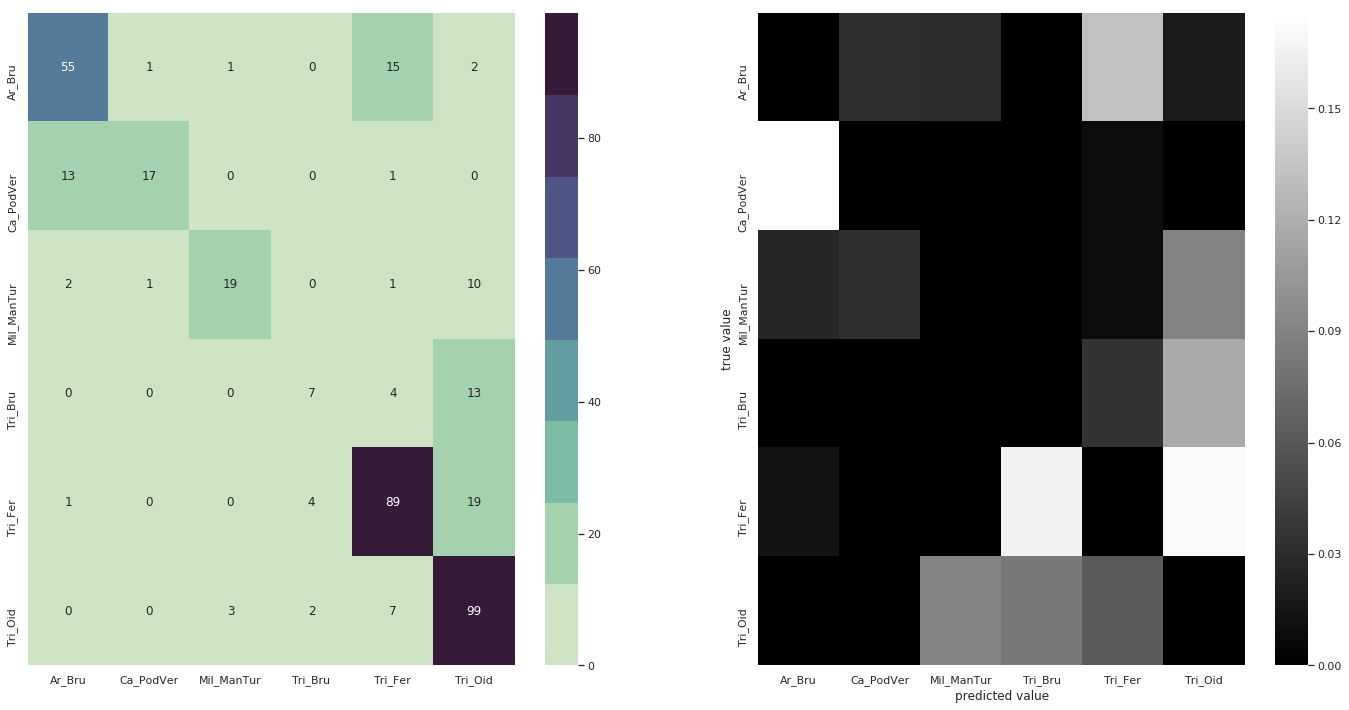

In [100]:
analise = Analyzation(attributes,Prediction=False)
analise.transform(task="RFCxRandSCV",Prediction=pred,Estimator_Score=sc,MatrizConfusion=cm,accuracy=AccuracyFinal,Best_Score=BSc,Best_Params=BtP,Class_Report=CRep)

### Trainando Com o Classificador Knn, O Optimizador RandomSearchCV 

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   34.7s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   48.5s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  4.6min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  5.6min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  6.4min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  7.0min finished
/home/Ibk_Akaigen/anaconda3/envs/TensorFlow/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. Th

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   36.6s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   51.7s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  4.0min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  4.8min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  5.9min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  6.8min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  7.4min finished
/home/Ibk_Akaigen/anaconda3/envs/TensorFlow/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. Th

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   37.3s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   51.8s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  4.0min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  4.9min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  6.0min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  6.8min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  7.4min finished
/home/Ibk_Akaigen/anaconda3/envs/TensorFlow/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. Th

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   37.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   52.6s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  4.0min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  4.9min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  6.0min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  6.8min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  7.4min finished
/home/Ibk_Akaigen/anaconda3/envs/TensorFlow/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. Th

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   37.3s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   52.1s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  4.1min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  4.9min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  6.0min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  6.8min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  7.4min finished
/home/Ibk_Akaigen/anaconda3/envs/TensorFlow/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. Th

 Score:  1.0


 Acuracy: 69.69%
Margin of Error for More and Less: 0.00%
 Best Score:  0.6844444444444444

 Best Params:

 {'weights': 'uniform', 'p': 2, 'n_neighbors': 5, 'leaf_size': 10}

 Classification Report:

               precision    recall  f1-score   support

           0       0.72      0.53      0.61        74
           1       0.84      0.52      0.64        31
           2       0.90      0.27      0.42        33
           3       0.70      0.29      0.41        24
           4       0.66      0.90      0.76       113
           5       0.70      0.86      0.77       111

    accuracy                           0.70       386
   macro avg       0.75      0.56      0.60       386
weighted avg       0.72      0.70      0.67       386



<Figure size 432x288 with 0 Axes>

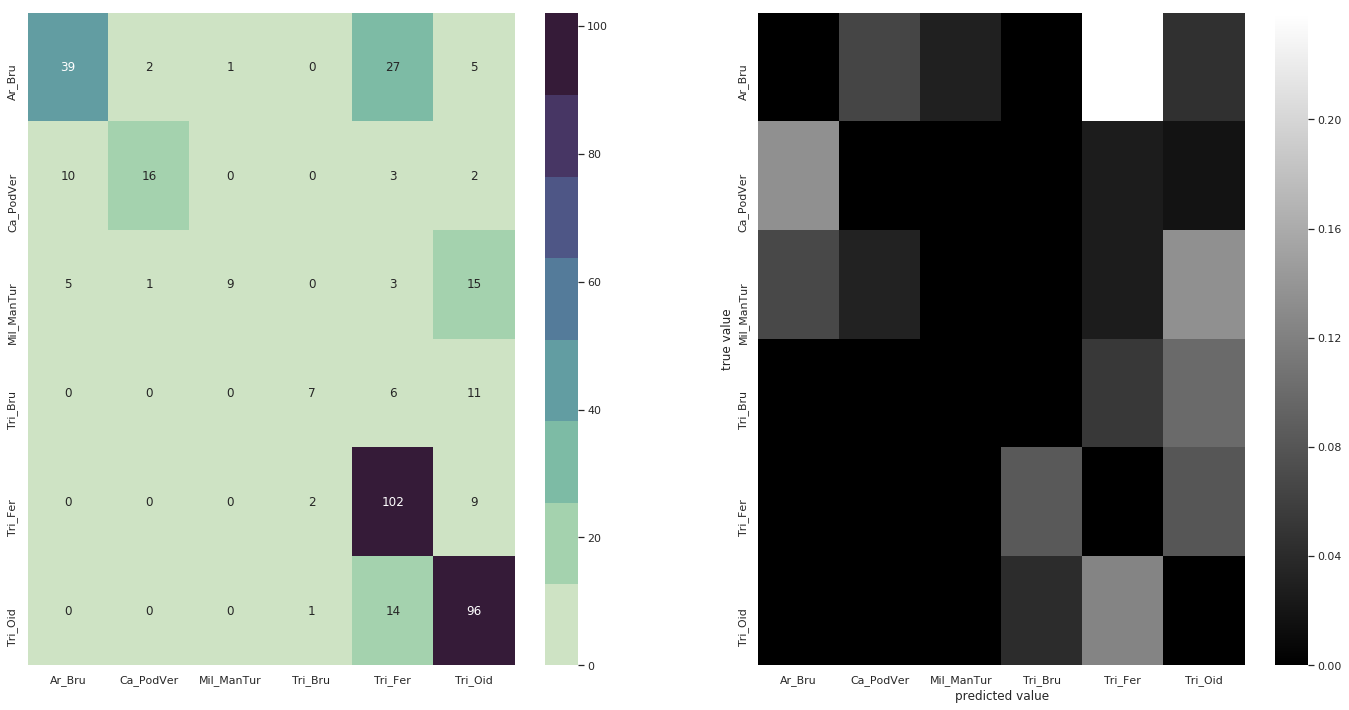

In [102]:
# Definindo os labels da pasta das imagens
attributes = ["Ar_Bru","Ca_PodVer","Mil_ManTur","Tri_Bru","Tri_Fer","Tri_Oid"]

# Definido os parametros para o optimizado escolhido
params_Opt ={'n_neighbors': [3,5,10,15,20,25,30,35,40],'weights':['uniform','distance'],
             'leaf_size':[3,5,10,15,20,25,30,35,40,45,50],
             'p':[1,2],
             'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']}

# Varíavel para armazenar as melhores accuracias em cada iteração  
AccuracyFinal=[]

# Carregar na memoria os DataSet
Dados = load_reshape("TrainSet","TestSet")

#Iniciar o carregamento dos dados de Treinamento e de Test
X_Train,y_Train,X_test,y_test = Dados.transform()

# Definido o modelo de Classificação
model = TrainingModel(Rfc=False,Knn=True,Svc=False)

#Iniciar o treinamento com o classificador escolhido
knn = model.transform(X_Train,y_Train)

# Definido o modelo de Optimização
Optimus = Optimization(knn,params_Opt,RandSearchCV=True,
                      AdaBoostCLF=False,BaggCLF=False,GradBCLF=False)

#Executar varia vezes o algoritmo de optimização para obtenção dos melhores parametros 
for i in range(5):
    
    #iniciando a Optimazação com o algoritmo escolhido
    RandS = Optimus.transform(X_Train,y_Train)
    
    # Setando os parametros na obtenção dos resultados
    result=  Outcome(attributes=attributes,Training_model=knn,Optimus_model=RandS)
    pred,sc,cm,ac,BSc, BtP, CRep = result.transform(X_Train,X_test,y_test)
    AccuracyFinal.append(ac)
    
AccuracyFinal= np.array(AccuracyFinal)

# Setando os parametros de resultados ser Analizado
analise = Analyzation(attributes,Prediction=False)

# Imprimir na tela os resultados no intuito de AnaliseS
analise.transform(task="knn",Prediction=pred,Estimator_Score=sc,MatrizConfusion=cm,accuracy=AccuracyFinal,Best_Score=BSc,Best_Params=BtP,Class_Report=CRep)

[LibSVM]Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  4.7min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  6.8min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  8.1min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  9.9min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed: 10.6min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed: 12.8min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed: 14.7min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed: 15.6min finished
/home/Ibk_Akaigen/anaconda3/envs/TensorFlow/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. Th

[LibSVM]

/home/Ibk_Akaigen/anaconda3/envs/TensorFlow/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=8).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/Ibk_Akaigen/anaconda3/envs/TensorFlow/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/Ibk_Akaigen/anaconda3/envs/TensorFlow/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/Ibk_Akaigen/anaconda3/envs/TensorFlow/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined an

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  4.3min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  6.4min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  7.7min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  9.5min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed: 10.3min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed: 12.4min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed: 14.3min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed: 15.2min finished
/home/Ibk_Akaigen/anaconda3/envs/TensorFlow/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  Deprecati

[LibSVM]

/home/Ibk_Akaigen/anaconda3/envs/TensorFlow/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=8).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/Ibk_Akaigen/anaconda3/envs/TensorFlow/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/Ibk_Akaigen/anaconda3/envs/TensorFlow/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/Ibk_Akaigen/anaconda3/envs/TensorFlow/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined an

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  4.3min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  6.5min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  7.8min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  9.6min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed: 10.2min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed: 12.4min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed: 14.3min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed: 15.2min finished
/home/Ibk_Akaigen/anaconda3/envs/TensorFlow/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  Deprecati

[LibSVM]

/home/Ibk_Akaigen/anaconda3/envs/TensorFlow/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=8).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/Ibk_Akaigen/anaconda3/envs/TensorFlow/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/Ibk_Akaigen/anaconda3/envs/TensorFlow/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/Ibk_Akaigen/anaconda3/envs/TensorFlow/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined an

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  4.2min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  6.4min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  7.6min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  9.4min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed: 10.2min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed: 12.3min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed: 14.2min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed: 15.1min finished
/home/Ibk_Akaigen/anaconda3/envs/TensorFlow/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  Deprecati

[LibSVM]

/home/Ibk_Akaigen/anaconda3/envs/TensorFlow/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=8).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/Ibk_Akaigen/anaconda3/envs/TensorFlow/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/Ibk_Akaigen/anaconda3/envs/TensorFlow/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/Ibk_Akaigen/anaconda3/envs/TensorFlow/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined an

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  4.4min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  6.6min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  7.8min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  9.7min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed: 10.4min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed: 12.6min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed: 14.6min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed: 15.5min finished
/home/Ibk_Akaigen/anaconda3/envs/TensorFlow/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  Deprecati

[LibSVM]

/home/Ibk_Akaigen/anaconda3/envs/TensorFlow/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=8).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/Ibk_Akaigen/anaconda3/envs/TensorFlow/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/Ibk_Akaigen/anaconda3/envs/TensorFlow/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/Ibk_Akaigen/anaconda3/envs/TensorFlow/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined an

 Score:  1.0


 Acuracy: 53.89%
Margin of Error for More and Less: 0.00%
 Best Score:  0.45444444444444443

 Best Params:

 {'shrinking': False, 'max_iter': 8, 'kernel': 'rbf', 'gamma': 2.1, 'degree': 2, 'decision_function_shape': 'ovo', 'C': 15.0}

 Classification Report:

               precision    recall  f1-score   support

           0       0.54      0.30      0.38        74
           1       0.00      0.00      0.00        31
           2       1.00      0.12      0.22        33
           3       0.00      0.00      0.00        24
           4       0.50      0.75      0.60       113
           5       0.56      0.87      0.69       111

    accuracy                           0.54       386
   macro avg       0.43      0.34      0.31       386
weighted avg       0.50      0.54      0.47       386



<Figure size 432x288 with 0 Axes>

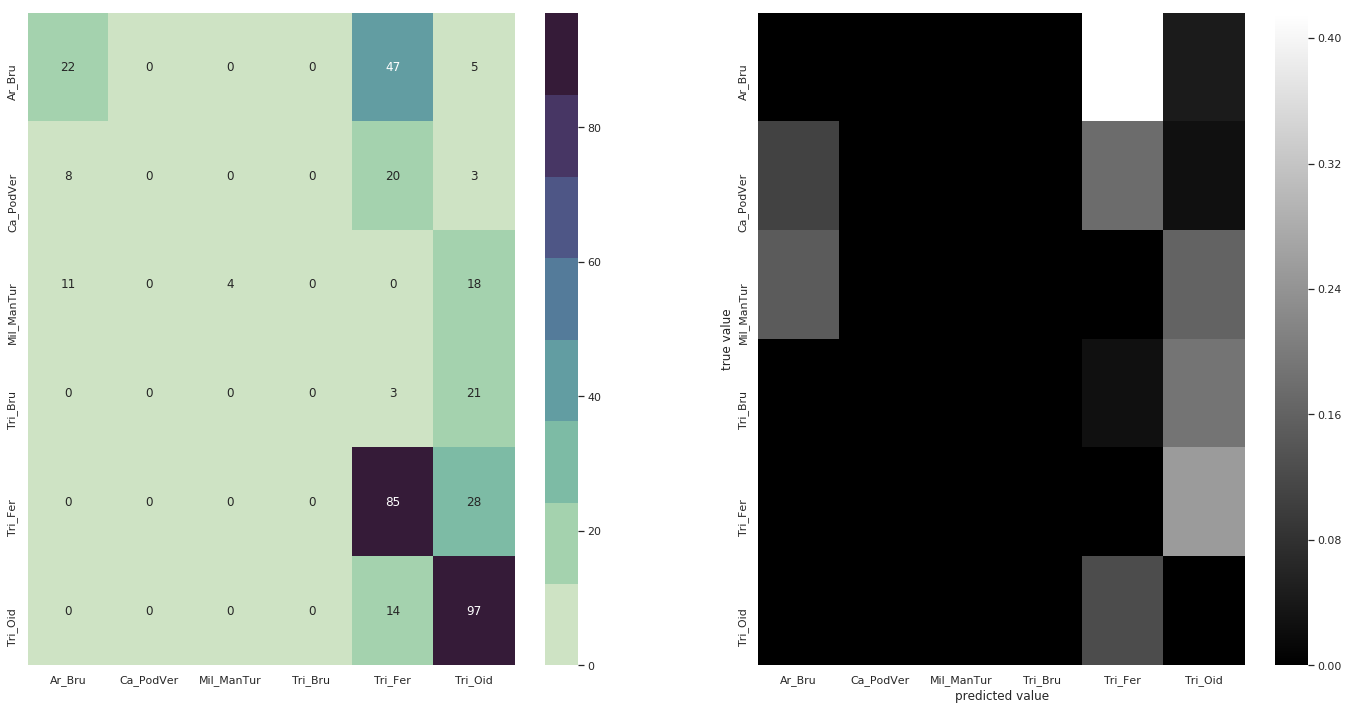

In [125]:
# Definindo os labels da pasta das imagens
attributes = ["Ar_Bru","Ca_PodVer","Mil_ManTur","Tri_Bru","Tri_Fer","Tri_Oid"]

# Definido os parametros para o optimizado escolhido
params_Opt ={'kernel':['rbf'],
             'gamma' :np.arange(0.1,50),'max_iter':np.arange(1,50),'C':np.arange(1.0,50),
             'decision_function_shape':['ovo','ovr'],
             'shrinking':[True,False],
             'degree':np.arange(1,10)}

#'kernel':['rbf','linear','poly','sigmoid','precomputed']

# Varíavel para armazenar as melhores accuracias em cada iteração  
AccuracyFinal=[]

# Carregar na memoria os DataSet
Dados = load_reshape("TrainSet","TestSet")

#Iniciar o carregamento dos dados de Treinamento e de Test
X_Train,y_Train,X_test,y_test = Dados.transform()

# Definido o modelo de Classificação
model = TrainingModel(Rfc=False,Knn=False,Svc=True)

#Iniciar o treinamento com o classificador escolhido
svc = model.transform(X_Train,y_Train)

# Definido o modelo de Optimização
Optimus = Optimization(svc,params_Opt,RandSearchCV=True,
                      AdaBoostCLF=False,BaggCLF=False,GradBCLF=False)

#Executar varia vezes o algoritmo de optimização para obtenção dos melhores parametros 
for i in range(5):
    
    #iniciando a Optimazação com o algoritmo escolhido
    RandS = Optimus.transform(X_Train,y_Train)
    
    # Setando os parametros na obtenção dos resultados
    result=  Outcome(attributes=attributes,Training_model=svc,Optimus_model=RandS)
    pred,sc,cm,ac,BSc, BtP, CRep = result.transform(X_Train,X_test,y_test)
    AccuracyFinal.append(ac)
    
AccuracyFinal= np.array(AccuracyFinal)

# Setando os parametros de resultados ser Analizado
analise = Analyzation(attributes,Prediction=False)

# Imprimir na tela os resultados no intuito de AnaliseS
analise.transform(task="svcXrandSCV",Prediction=pred,Estimator_Score=sc,MatrizConfusion=cm,accuracy=AccuracyFinal,Best_Score=BSc,Best_Params=BtP,Class_Report=CRep)